# Predicting Social with an LSTM
i.e., full dataset, transformed to PCA

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [2]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7559]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7559]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
print X_train.shape #(4472, 7555)
print Y_test.shape #(1044, )
print dummy_y_test.shape # (1044, 5)


(4472, 7555)
(1044,)
(1044, 4)


In [3]:
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

from sklearn import decomposition

pca = decomposition.PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 100 components:'
print sum(pca.explained_variance_ratio_)

Variance explained:
[ 0.19505564  0.08295663  0.04067402  0.02174272  0.01775119  0.01686748
  0.01440615  0.01150575  0.01055     0.00958828  0.00877439  0.00790115
  0.007298    0.00704889  0.0066142   0.00595329  0.00538577  0.00530285
  0.00491633  0.0045751   0.00440203  0.00436509  0.00395662  0.00343414
  0.00340722  0.00328142  0.00325585  0.00305899  0.00297009  0.00289683
  0.00281987  0.00273652  0.00266189  0.00265268  0.00260069  0.0024912
  0.00238337  0.00232648  0.00226495  0.00224082  0.00221907  0.00217391
  0.00215321  0.00208428  0.00204535  0.00198475  0.00192726  0.00190714
  0.00187787  0.00183914  0.00176811  0.00173735  0.00169542  0.00166308
  0.00165403  0.00162881  0.00161277  0.0015787   0.00157364  0.00155227
  0.0015123   0.00149719  0.00148685  0.00147954  0.00145035  0.00142099
  0.00141436  0.00141164  0.00138952  0.00136064  0.00134219  0.0013185
  0.00130973  0.00129871  0.00129763  0.0012655   0.00125215  0.00124378
  0.00122832  0.0012048   0.00119

In [4]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_deeper_dropout_decay_PCA():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(100,)))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.8, decay=0.0001, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def create_LSTM_PCA(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(20, batch_input_shape=(batch_size, 1, trainShape1), 
                   stateful=True))
    model.add(Dense(5, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM3_PCA_Social(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM3_PCA_Social()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape




____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_1 (LSTM)                      (1, 1, 200)         240800      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)                (1, 1, 200)         0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                      (1, 1, 100)         120400      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)                (1, 1, 100)         0           lstm_2[0][0]                     
___________________________________________________________________________________________

('Epoch', 1, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 72s - loss: 0.8787 - acc: 0.6525 - val_loss: 1.4929 - val_acc: 0.5872
Performance of model on test set ----------------------------
Accuracy:
0.588122605364
Confusion matrix:
[[608   0  39   0]
 [ 98   0 121   0]
 [ 18   0   6   0]
 [133   0  21   0]]
AUC score:
0.711058989924
('Epoch', 2, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 80s - loss: 0.7523 - acc: 0.7433 - val_loss: 1.3930 - val_acc: 0.6073
Performance of model on test set ----------------------------
Accuracy:
0.602490421456
Confusion matrix:
[[623   0  24   0]
 [101   0 118   0]
 [ 18   0   6   0]
 [120   0  34   0]]
AUC score:
0.72320964062
('Epoch', 3, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 101s - loss: 0.6344 - acc: 0.7880 - val_loss: 1.2419 - val_acc: 0.5728

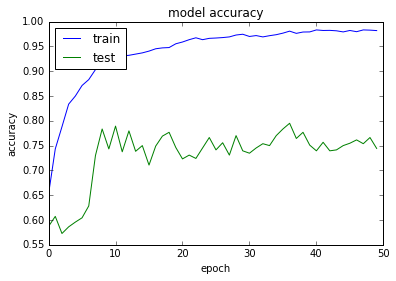

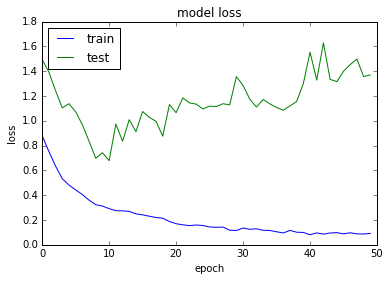

In [9]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("social.model--3lstm.json", "w") as json_file:
    json_file.write(model_json)
filepath="social.weights--3lstm.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)


# Fit the model
batch_size = 1
nb_epochs = 50
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    model.reset_states()
    # Estimate model performance, and reset states!
    printValStats(model, testX, dummy_y_test)


#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/
import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value

# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Do a combined ActivitySocial prediction too

In [5]:
Y_train_both = ["%s%s" % t for t in zip(train[:,7558], train[:,7559])]
Y_test_both = ["%s%s" % t for t in zip(test[:,7558], test[:,7559])]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train_both)
encoded_Y_train_both = encoder.transform(Y_train_both)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train_both = to_categorical(encoded_Y_train_both)
#encoder.fit(Y_test_both) #May have less combinations, stick to the train set ones
encoded_Y_test_both = encoder.transform(Y_test_both)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test_both = to_categorical(encoded_Y_test_both)

from scipy import stats


print X_train.shape #(4472, 7555)
print Y_test.shape
print len(Y_test_both) #(1044, )
print dummy_y_train_both.shape # (1044, 5)
print stats.describe(dummy_y_test_both).mean # (1044, 5)

(4472, 7555)
(1044,)
1044
(4472, 15)
[ 0.19157088  0.          0.20210728  0.10632184  0.00287356  0.13984674
  0.02873563  0.00670498  0.14750958  0.08045977  0.00862069  0.00191571
  0.00574713  0.06609195  0.01149425]


In [29]:
def create_LSTM3_PCA_ActivitySocial(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(300, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(150, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(75, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM3_PCA_ActivitySocial()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_19 (LSTM)                     (1, 1, 300)         481200      lstm_input_7[0][0]               
____________________________________________________________________________________________________
dropout_31 (Dropout)               (1, 1, 300)         0           lstm_19[0][0]                    
____________________________________________________________________________________________________
lstm_20 (LSTM)                     (1, 1, 150)         270600      dropout_31[0][0]                 
____________________________________________________________________________________________________
dropout_32 (Dropout)               (1, 1, 150)         0           lstm_20[0][0]                    
___________________________________________________________________________________________

('Epoch', 1, '/', 100)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 110s - loss: 1.8979 - acc: 0.4030 - val_loss: 3.9592 - val_acc: 0.0613
Performance of model on test set ----------------------------
Accuracy:
0.0613026819923
Confusion matrix:
[[  0 198   0   0   0   0   0   0   0   0   0   0   0   2]
 [  0  63   0   0   0   0   0   0   0   0   0   0   0 148]
 [  0  32   0   0   0   0   0   0   0   0   0   0   0  79]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [  0 133   0   0   0   0   0   0   0   0   0   0   0  13]
 [  0  18   0   0   0   0   0   0   0   0   0   0   0  12]
 [  0   4   0   0   0   0   0   0   0   0   0   0   0   3]
 [  0  64   0   0   0   0   0   0   0   0   0   0   0  90]
 [  0  84   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   5   0   0   0   0   0   0   0   0   0   0   0   4]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   1]
 [  0   5   0   0   0   0   0   0   0   0   0   

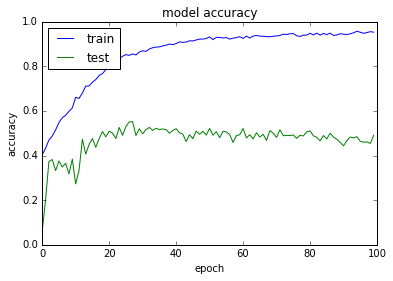

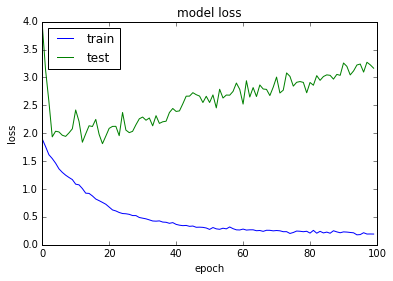

In [ ]:
# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("activitysocial.model--3lstm.json", "w") as json_file:
    json_file.write(model_json)
filepath="activitysocial.weights--3lstm.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
batch_size = 1
nb_epochs = 100
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train_both, validation_data=(testX,dummy_y_test_both), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    model.reset_states()
    # Estimate model performance, and reset states!
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test_both, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test_both, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC cannot be calculated because there is a missing state in the test set!
    #roc = roc_auc_score(dummy_y_test_both, Y_pred, average='macro')
    #print('AUC score:')
    #print(roc)


#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/
import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value

# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

... and compare it with the combination of the best models predicting activity and social separately -- who is better?

...also, the resulting accuracy, if translated back to separate variables, what does it give us? better or worse than the separate models?

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from keras.models import model_from_json
import numpy
import os

def load_model_weights(modelfile, weightsfile, lossmethod='categorical_crossentropy', optmethod='adam'):
    json_file = open(modelfile,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weightsfile)
    print("Loaded model from disk")
    # evaluate loaded model on test data
    loaded_model.compile(loss=lossmethod, optimizer=optmethod, metrics=['accuracy'])
    return loaded_model

def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)

batch_size=1
    
# We load the activitysocial model, and predict on the test set, and evaluate
model = load_model_weights('activitysocial.model--3lstm.json', 'activitysocial.weights--3lstm--acc55.hdf5')
Y_pred = model.predict(testX, batch_size=batch_size)
model.reset_states()
print 'Performance of ActivitySocial model on test set ----------------------------'
# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(dummy_y_test_both, axis=1), numpy.argmax(Y_pred, axis=1)))
# Confusion matrix
cm = confusion_matrix(numpy.argmax(dummy_y_test_both, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

Loaded model from disk
Performance of ActivitySocial model on test set ----------------------------
Accuracy:
0.556513409962
Confusion matrix:
[[169  13   0   0  13   0   0   1   2   0   0   2   0   0]
 [  9 164  11   0   6   0   0  16   1   0   0   0   4   0]
 [  2  63  37   0   0   0   0   3   0   4   0   0   2   0]
 [  0   0   2   0   0   0   0   0   0   1   0   0   0   0]
 [ 32  28   1   0  60   3   0  10   6   0   0   2   4   0]
 [  0   9   6   0   0   2   0   1   0   0   0   0  12   0]
 [  1   3   1   0   0   0   2   0   0   0   0   0   0   0]
 [  3  31   9   3   2   1   0  94   2   0   0   7   0   2]
 [ 29   7   0   1   8   0   0   0  32   0   0   7   0   0]
 [  0   2   2   0   0   0   0   0   0   2   0   0   3   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   1   0   0   0   0   1   0   0   0   0   0   0]
 [  0  13  27   0   1   0   0   3   0   6   0   0  19   0]
 [  1   6   0   0   0   0   0   1   0   0   0   0   4   0]]


In [22]:
# Decode the predictions back to the original values
encoded_pred = numpy.argmax(Y_pred, axis=1)
both_pred = encoder.inverse_transform(encoded_pred)

# Split the predictions into activity and social
def split_act_soc(input):
    act_pred = []
    soc_pred = []
    for value in input:
        if value.startswith('Other'):
            act_pred.append('Other')
            soc_pred.append(value[5:])
        elif value.startswith('EXP'):
            act_pred.append('EXP')
            soc_pred.append(value[3:])
        elif value.startswith('MON'):
            act_pred.append('MON')
            soc_pred.append(value[3:])
        elif value.startswith('REP'):
            act_pred.append('REP')
            soc_pred.append(value[3:])
        elif value.startswith('QUE'):
            act_pred.append('QUE')
            soc_pred.append(value[3:])
        else:
            print 'Unexpected value!!'
            return
    return act_pred, soc_pred

act_pred, soc_pred = split_act_soc(both_pred)

print len(both_pred), len(act_pred), len(soc_pred)

# Create Activity and social ground truth (again)
Y_testAct = test[:,7558]
Y_testSoc = test[:,7559]

encoderA = LabelEncoder()
encoderA.fit(Y_testAct)
encoded_Y_testAct = encoderA.transform(Y_testAct)
encoded_Y_predAct = encoderA.transform(act_pred)
dummy_y_testAct = to_categorical(encoded_Y_testAct)
dummy_y_predAct = to_categorical(encoded_Y_predAct)
encoderS = LabelEncoder()
encoderS.fit(Y_testSoc)
encoded_Y_testSoc = encoderS.transform(Y_testSoc)
encoded_Y_predSoc = encoderS.transform(soc_pred)
dummy_y_testSoc = to_categorical(encoded_Y_testSoc)
dummy_y_predSoc = to_categorical(encoded_Y_predSoc)


# Evaluate activity and social predictions separately
print 'Activity scores from a dual prediction:'
print 'Accuracy', accuracy_score(Y_testAct, act_pred)
print 'Confusion matrix:\n', confusion_matrix(Y_testAct, act_pred)
print 'AUC', roc_auc_score(dummy_y_testAct, dummy_y_predAct, average='macro')

print '==========================================='
print 'Activity scores from a dual prediction:'
print 'Accuracy', accuracy_score(Y_testSoc, soc_pred)
print 'Confusion matrix:\n', confusion_matrix(Y_testSoc, soc_pred)
print 'AUC', roc_auc_score(dummy_y_testSoc, dummy_y_predSoc, average='macro')


# How does it compare with the best activity (acc65, auc83) and social (acc79, auc81)

1044 1044 1044
Activity scores from a dual prediction:
Accuracy 0.649425287356
Confusion matrix:
[[169  13  14   2   2]
 [ 11 277  25   6   6]
 [ 36  91 175   8  27]
 [ 29  14   8  34  10]
 [  5  47   6   6  23]]
AUC 0.736823223866
Activity scores from a dual prediction:
Accuracy 0.777777777778
Confusion matrix:
[[594  24   1  28]
 [ 90 122   0   7]
 [ 13   8   2   1]
 [ 45  10   5  94]]
AUC 0.71235589745


Thus, the dual prediction performs quite well, but does not beat our best separate models